# Bridging the Gaps in LLM Interpretability of Unstructured Financial Earnings Data with Knowledge Graphs
- Use case: answer questions about companies' financial performance based on the transcripts of their earnings calls.
- Uses StrictJSON to parse the Knowledge Graph: https://github.com/tanchongmin/strictjson

## Import packages

In [17]:
!pip install pandas nltk scikit-learn

In [1]:
from strictjson import *
import os
import openai
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
import pandas as pd
import numpy as np

In [2]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

## Load dataset

In [3]:
# Function to parse JSONL file
def parse_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

file_path = 'data/earnings-transcripts.jsonl'
earnings_data = parse_jsonl(file_path)


In [21]:
df = pd.DataFrame(earnings_data)

In [22]:
df.head()

,date,exchange,q,ticker,transcript
0,"Aug 27, 2020, 9:00 p.m. ET",NASDAQ: BILI,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,"Jul 30, 2020, 4:30 p.m. ET",NYSE: GFF,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,"Oct 23, 2019, 5:00 p.m. ET",NASDAQ: LRCX,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,"Nov 6, 2019, 12:00 p.m. ET",NASDAQ: BBSI,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,"Aug 7, 2019, 8:30 a.m. ET",NASDAQ: CSTE,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        1000 non-null   object
 1   exchange    1000 non-null   object
 2   q           1000 non-null   object
 3   ticker      1000 non-null   object
 4   transcript  1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB


In [24]:
df.describe()

,date,exchange,q,ticker,transcript
count,1000,1000,1000,1000,1000
unique,783,703,22,703,962
top,"May 27, 2020, 9:00 p.m. ET",NASDAQ: TSLA,2020-Q4,TSLA,"Prepared Remarks:\nOperator\nGood morning, and..."
freq,7,8,210,8,7


In [25]:
# Remove data and exchange columns as they are not needed
df = df[['q', 'ticker', 'transcript']]
df.head()

,q,ticker,transcript
0,2020-Q2,BILI,"Prepared Remarks:\nOperator\nGood day, and wel..."
1,2020-Q3,GFF,Prepared Remarks:\nOperator\nThank you for sta...
2,2020-Q1,LRCX,Prepared Remarks:\nOperator\nGood day and welc...
3,2019-Q3,BBSI,"Prepared Remarks:\nOperator\nGood day, everyon..."
4,2019-Q2,CSTE,Prepared Remarks:\nOperator\nGreetings and wel...


In [26]:
# Create new df only with rows with specific tickers
tickers = ['TSM', 'COHR', 'SWKS', 'ASML', 'MTSI']
df_new = df[df['ticker'].isin(tickers)]
df_new

,q,ticker,transcript
15,2020-Q4,TSM,Prepared Remarks:\nJeff Su -- Director of Inve...
136,2023-Q1,COHR,Prepared Remarks:\nOperator\nLadies and gentle...
153,2022-Q3,TSM,"Prepared Remarks:\nJeff Su\nGood afternoon, ev..."
225,2021-Q4,MTSI,Prepared Remarks:\nOperator\nWelcome to MACOM'...
506,2021-Q4,MTSI,Prepared Remarks:\nOperator\nWelcome to MACOM'...
511,2023-Q2,COHR,"Prepared Remarks:\nOperator\nGood day, and tha..."
591,2019-Q4,MTSI,"Prepared Remarks:\nOperator\nGood afternoon, a..."
596,2023-Q2,COHR,"Prepared Remarks:\nOperator\nGood day, and tha..."
620,2020-Q2,SWKS,Prepared Remarks:\nOperator\nGood afternoon an...
924,2022-Q1,SWKS,"Prepared Remarks:\nOperator\nGood afternoon, a..."


In [27]:
# Count words for each transcript
df_new['word_count'] = df_new['transcript'].apply(lambda x: len(x.split()))
df_new

/var/folders/xb/h3ltfn611fg9ycm0s6vn5qpw0000gn/T/ipykernel_15472/1508092007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['word_count'] = df_new['transcript'].apply(lambda x: len(x.split()))


,q,ticker,transcript,word_count
15,2020-Q4,TSM,Prepared Remarks:\nJeff Su -- Director of Inve...,12478
136,2023-Q1,COHR,Prepared Remarks:\nOperator\nLadies and gentle...,11602
153,2022-Q3,TSM,"Prepared Remarks:\nJeff Su\nGood afternoon, ev...",10069
225,2021-Q4,MTSI,Prepared Remarks:\nOperator\nWelcome to MACOM'...,11095
506,2021-Q4,MTSI,Prepared Remarks:\nOperator\nWelcome to MACOM'...,11095
511,2023-Q2,COHR,"Prepared Remarks:\nOperator\nGood day, and tha...",10960
591,2019-Q4,MTSI,"Prepared Remarks:\nOperator\nGood afternoon, a...",7136
596,2023-Q2,COHR,"Prepared Remarks:\nOperator\nGood day, and tha...",10960
620,2020-Q2,SWKS,Prepared Remarks:\nOperator\nGood afternoon an...,8089
924,2022-Q1,SWKS,"Prepared Remarks:\nOperator\nGood afternoon, a...",7562


## Utility functions

In [4]:
def chat(system_prompt, user_prompt = '', model = 'gpt-4-turbo', temperature = 0, **kwargs):
    ''' This replies the user based on a system prompt and user prompt to call OpenAI Chat Completions API '''
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        temperature = temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        **kwargs
    )
    res = response.choices[0].message.content
    return res

## Data Preprocessing

In [30]:
# Function to summarize text
def summarize_text(text):
    '''Summarize long text to a shorter format'''
    completion = openai.chat.completions.create(
        model="gpt-4-turbo",
        messages=[{"role": "user", "content": f"Summarize the following text to 600 words while keeping all the essential information: {text}"}],
    )
    return completion.choices[0].message.content

In [31]:
# Summarize the transcript column and create a new column with the summarized text
df_new['summary'] = df_new['transcript'].apply(summarize_text)

/var/folders/xb/h3ltfn611fg9ycm0s6vn5qpw0000gn/T/ipykernel_15472/1866686743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['summary'] = df_new['transcript'].apply(summarize_text)


In [32]:
# Count summarized words for each transcript
df_new['summary_word_count'] = df_new['summary'].apply(lambda x: len(x.split()))
df_new

/var/folders/xb/h3ltfn611fg9ycm0s6vn5qpw0000gn/T/ipykernel_15472/3785242265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['summary_word_count'] = df_new['summary'].apply(lambda x: len(x.split()))


,q,ticker,transcript,word_count,summary,summary_word_count
15,2020-Q4,TSM,Prepared Remarks:\nJeff Su -- Director of Inve...,12478,"Prepared Remarks:\nJeff Su, Director of Invest...",470
136,2023-Q1,COHR,Prepared Remarks:\nOperator\nLadies and gentle...,11602,"Operator\nLadies and gentlemen, welcome to the...",554
153,2022-Q3,TSM,"Prepared Remarks:\nJeff Su\nGood afternoon, ev...",10069,"Good afternoon, everyone, and welcome to TSMC'...",526
225,2021-Q4,MTSI,Prepared Remarks:\nOperator\nWelcome to MACOM'...,11095,"MACOM Technology Solutions Holdings, Inc. (MAC...",418
506,2021-Q4,MTSI,Prepared Remarks:\nOperator\nWelcome to MACOM'...,11095,Welcome to the summary of MACOM's Fourth Fisca...,386
511,2023-Q2,COHR,"Prepared Remarks:\nOperator\nGood day, and tha...",10960,Operator:\nWelcome to Coherent Corp.'s FY '23 ...,280
591,2019-Q4,MTSI,"Prepared Remarks:\nOperator\nGood afternoon, a...",7136,Operator:\nWelcome to MACOM's fourth fiscal qu...,301
596,2023-Q2,COHR,"Prepared Remarks:\nOperator\nGood day, and tha...",10960,Operator\nWelcome to the Coherent Corp. FY '23...,371
620,2020-Q2,SWKS,Prepared Remarks:\nOperator\nGood afternoon an...,8089,"Operator:\nGood afternoon, welcome to Skyworks...",354
924,2022-Q1,SWKS,"Prepared Remarks:\nOperator\nGood afternoon, a...",7562,"Operator\nGood afternoon, and welcome to Skywo...",423


In [5]:
# Save to csv to avoid re-summarizing
df_new.to_csv('data/earnings-transcripts-summarized.csv', index=False)

NameError: name 'df_new' is not defined

In [6]:
df_earnings = pd.read_csv('data/earnings-transcripts-summarized.csv')

In [ ]:
import re
def normalize_text(text):
    text = re.sub(r'[^\S\n]+', ' ', text)
    text = text.strip()
    return text

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pattssun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pattssun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Normalize, lemmatize, remove stop words from each transcript summary and store in a new column
df_earnings['clean_summary'] = df_earnings['summary'].apply(normalize_text)
df_earnings['clean_summary'] = df_earnings['clean_summary'].apply(lemmatize_text)
df_earnings['clean_summary'] = df_earnings['clean_summary'].apply(remove_stop_words)

In [ ]:
# Compare summary with clean_summary
df_earnings[['summary', 'clean_summary']].head()

,summary,clean_summary
0,"Prepared Remarks:\nJeff Su, Director of Invest...","Prepared Remarks: Jeff Su, Director Investor R..."
1,"Operator\nLadies and gentlemen, welcome to the...","Operator Ladies gentlemen, welcome Coherent Co..."
2,"Good afternoon, everyone, and welcome to TSMC'...","Good afternoon, everyone, welcome TSMC's third..."
3,"MACOM Technology Solutions Holdings, Inc. (MAC...","MACOM Technology Solutions Holdings, Inc. (MAC..."
4,Welcome to the summary of MACOM's Fourth Fisca...,Welcome summary MACOM's Fourth Fiscal Quarter ...


## Build Knowledge Graph

In [7]:
def build_knowledge_graph(transcript_summary):
    '''Extract knowledge graph from summarized text using schema'''
    completion = openai.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": '''You are a knowledge graph builder, extract nodes and edges for a knowledge graph from the following text.
            You are to output relations between two objects in the form (object_1, relation, object_2). 
            All information about dates must be included.
            Example Input: John bought a laptop
            Example Output: [('John', 'bought', 'laptop')]
            Example Input: John built a house in 2019
            Example Output: [('John', 'built', 'house'), ('house', 'built in', '2019')]
            The final output should be in JSON as follows: {"List of triplets": "List of triplets of the form (object_1, relation, object_2), type: list"}'''},
            {"role": "user", "content": f"Here's the text: {transcript_summary}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    return answer

In [8]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg)

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

In [51]:
# Build knowledge graph for each transcript clean summary
df_earnings['knowledge_graph'] = df_earnings['clean_summary'].apply(build_knowledge_graph)

In [53]:
# Save df_earnings to csv to avoid re-building knowledge graph
df_earnings.to_csv('data/earnings-transcripts-kg.csv', index=False)

In [11]:
# convert csv to dataframe
df_earnings = pd.read_csv('data/earnings-transcripts-kg.csv')

In [12]:
df_earnings.head()

,q,ticker,transcript,word_count,summary,summary_word_count,clean_summary,knowledge_graph
0,2020-Q4,TSM,Prepared Remarks:\nJeff Su -- Director of Inve...,12478,"Prepared Remarks:\nJeff Su, Director of Invest...",470,"Prepared Remarks: Jeff Su, Director Investor R...","{'List of triplets': [['Jeff Su', 'is Director..."
1,2023-Q1,COHR,Prepared Remarks:\nOperator\nLadies and gentle...,11602,"Operator\nLadies and gentlemen, welcome to the...",554,"Operator Ladies gentlemen, welcome Coherent Co...","{'List of triplets': [['Coherent Corp', 'hoste..."
2,2022-Q3,TSM,"Prepared Remarks:\nJeff Su\nGood afternoon, ev...",10069,"Good afternoon, everyone, and welcome to TSMC'...",526,"Good afternoon, everyone, welcome TSMC's third...","{'List of triplets': [['TSMC', 'hosted', 'thir..."
3,2021-Q4,MTSI,Prepared Remarks:\nOperator\nWelcome to MACOM'...,11095,"MACOM Technology Solutions Holdings, Inc. (MAC...",418,"MACOM Technology Solutions Holdings, Inc. (MAC...",{'List of triplets': [['MACOM Technology Solut...
4,2021-Q4,MTSI,Prepared Remarks:\nOperator\nWelcome to MACOM'...,11095,Welcome to the summary of MACOM's Fourth Fisca...,386,Welcome summary MACOM's Fourth Fiscal Quarter ...,"{'List of triplets': [['MACOM', 'had earnings ..."


In [15]:
# Plot knowledge graph for the first transcript
kg = df_earnings['knowledge_graph'][0]['List of triplets']
plot_graph(kg)

TypeError: string indices must be integers, not 'str'

## Parse Knowledge Graph

In [56]:
# def parse_knowledge_graph(kg, question):
#     '''Parse knowledge graph to extract relevant relations'''
#     completion = openai.chat.completions.create(
#         model="gpt-4-turbo",
#         response_format={ "type": "json_object" },
#         messages=[
#             {"role": "system", "content": f'''You are a knowledge graph parser for the following knowledge graph {kg}. 
#             Only output the triplets that are relevant to the question.
#             The final output should be in JSON as follows: {"Parsed Knowledge Graph": "List of triplets of the form (object1, relation, object2), type: list"}'''},
#             {"role": "user", "content": f"Here's the question: {question}"}
#         ]
#     )

#     answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

#     return answer

In [57]:
triplets_text = ["{} {} {}".format(src, rel, trg) for src, rel, trg in kg]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(triplets_text)

In [68]:
question = "What is the expected revenue growth rate for TSMC from 2020 to 2025 in US dollar terms"
query_vector = vectorizer.transform([question])
similarity_scores = cosine_similarity(query_vector, tfidf_matrix)[0]
print(similarity_scores)

[0.15945388 0.034025   0.         0.07915075 0.20671698 0.04059611
 0.07175265 0.04445658 0.03914005 0.03847574 0.03487279 0.21276046
 0.33820155 0.19127015 0.19532939 0.13950886 0.14278155 0.23790757
 0.22952955 0.23270557 0.23270557 0.19645593 0.32770995 0.13745994
 0.10694529 0.12973258 0.10069001 0.09927561 0.04732378 0.02660869
 0.18420565 0.48020193 0.         0.         0.0589088  0.08288286
 0.06398596 0.10530552]


In [69]:
import numpy as np

threshold = 0.2
relevant_indices = np.where(similarity_scores > threshold)[0]
relevant_triplets = [kg[i] for i in relevant_indices]

print(f"Relevant Triplets: {relevant_triplets}")

Relevant Triplets: [['Wendell Huang', 'is CFO at', 'TSMC'], ['TSMC', 'saw sequential increase in revenue by', '1.4% in Q4 2020'], ['TSMC', 'saw increase in revenue by', '4.4% in USD terms in Q4 2020'], ['revenue from smartphones', 'rose by', '13% in Q4 2020'], ['revenue from HPC', 'fell by', '14% in Q4 2020'], ['revenue from IoT', 'dropped by', '13% in Q4 2020'], ['revenue from automotive', 'increased by', '27% in Q4 2020'], ["TSMC's revenue", 'grew by', '31.4% in USD terms in 2020'], ['TSMC', 'projects CAGR to increase by', '10% to 15% from 2020 to 2025 in USD terms']]


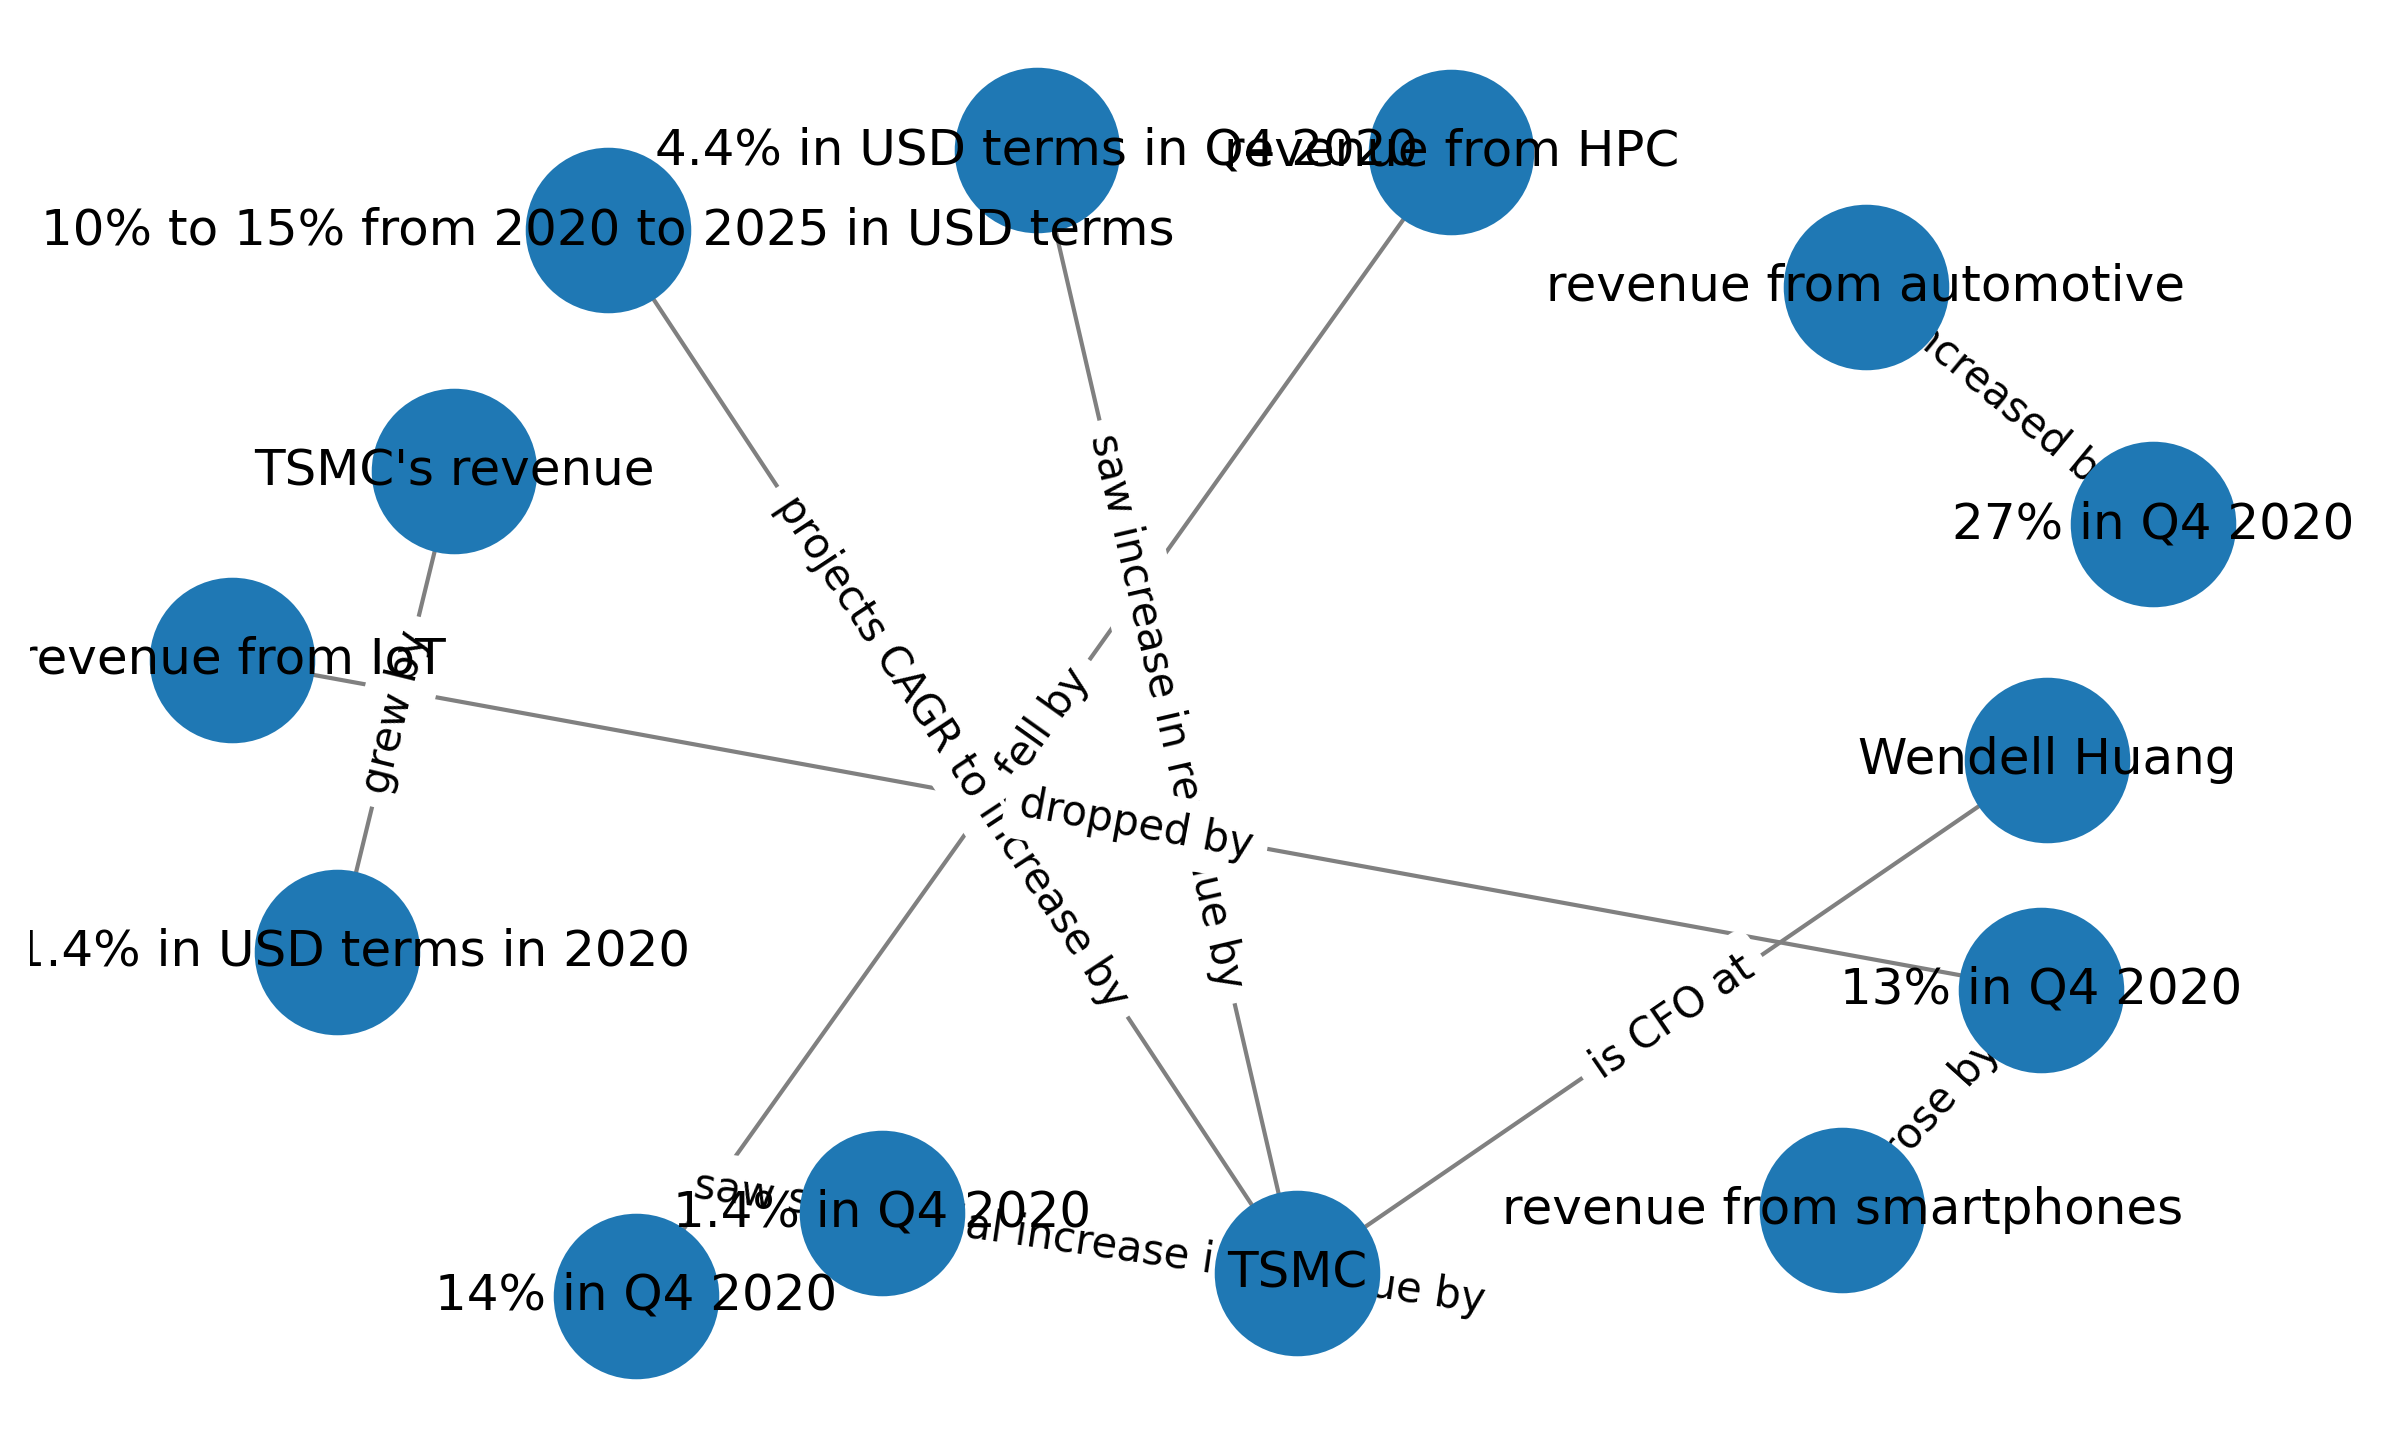

In [70]:
# Plot knowledge graph based on relevant triplets
plot_graph(relevant_triplets)

## Generate Answer

In [74]:
# Ground truth answer
answer_from_QA = "The expected revenue growth rate for TSMC from 2020 to 2025 in US dollar terms is 10% to 15% CAGR."

In [75]:
print('Question:', question)
print('Answer from Parsed Knowledge Graph:', chat(f'''Use the knowledge graph to answer the following question. 
If you are unsure, output 'No Info'
Knowledge Graph: {relevant_triplets}''',
                    user_prompt = f'''Question: {question}'''))
print('Ground Truth Answer:', answer_from_QA)

Question: What is the expected revenue growth rate for TSMC from 2020 to 2025 in US dollar terms
Answer from Parsed Knowledge Graph: TSMC projects CAGR to increase by 10% to 15% from 2020 to 2025 in USD terms.
Ground Truth Answer: The expected revenue growth rate for TSMC from 2020 to 2025 in US dollar terms is 10% to 15% CAGR.
